In [1]:
import pandas as pd
from datetime import datetime, timedelta, time, date
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import pickle
import json
pd.set_option('display.max_rows', 200)
%matplotlib inline

In [2]:
import pickle
import json
def write_pickle(data, path):
    
    with open(path, "wb") as f:
        pickle.dump(data, f)

def read_pickle(path):
    
    with open(path, "rb") as f:
        return pickle.load(f)
    
def write_json(data, path):
    
    with open(path, "w") as f:
        json.dump(data, f)
        
def read_json(path):
    
    with open(path, "rb") as f:
        return json.load(f)

In [3]:
# split and merge the time interval across the two days

def generate_time_range(row):
    
    start_date = row['start_time'].date()
    end_date = row['end_time'].date()
    
    if(start_date < end_date):
        result = []
        divide_line_dt = datetime.combine(start_date+timedelta(days = 1), time(0,0))
        result.append((row['start_time'], divide_line_dt))
        
        while(divide_line_dt.date() < end_date):
            result.append((divide_line_dt, divide_line_dt + timedelta(days = 1)))
            divide_line_dt = divide_line_dt + timedelta(days = 1)
        
        result.append((divide_line_dt, row['end_time']))
            
        return result
        
    else:
        return [(row['start_time'], row['end_time'])]

def split_continuous_time(df):
    
    # cross time range
    cross = df[df['start_time'].dt.date != df['end_time'].dt.date].copy()
    non_cross = df[df['start_time'].dt.date == df['end_time'].dt.date]
    
    cross['time_range'] = cross.apply(lambda row:generate_time_range(row), axis = 1)
    
    cross = cross.explode('time_range')
    cross['start_time'] = cross.apply(lambda row: row['time_range'][0], axis = 1)
    cross['end_time'] = cross.apply(lambda row: row['time_range'][1], axis = 1)
    
    cross = cross.drop('time_range', axis = 1)
    
    df = pd.concat([non_cross, cross])
    
    return df

## Data Preprocessing

## Main

In [4]:
df = pd.read_csv('./data/raw_data_all_merge_time.csv')
print(df.shape)
print(df.dtypes)
print(len(df.building.unique()))

#convert types
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['duration'] = df['end_time'] - df['start_time']

df.head()

(1841873, 10)
device_id     object
building      object
start_time    object
end_time      object
n_records      int64
n_ap           int64
user_id       object
user_id_m     object
ssid          object
ssid_m        object
dtype: object
155


,device_id,building,start_time,end_time,n_records,n_ap,user_id,user_id_m,ssid,ssid_m,duration
0,00010d9212f1dd42c505bc37917fe7843acdcec7,rzc,2020-08-27 09:33:00,2020-08-27 09:33:00,2,1,['6ed3ad5351155640be9fdb2a5fa4610452f86a95'],6ed3ad5351155640be9fdb2a5fa4610452f86a95,['USC Secure Wireless'],USC Secure Wireless,0 days 00:00:00
1,00014b5eb675babe57e4da111eb66704a6210ef1,dwe-gate6,2020-09-02 12:08:00,2020-09-02 12:09:00,1,1,['27d3d1b265a29b735b64f913179720ee4996840a'],27d3d1b265a29b735b64f913179720ee4996840a,['USC Secure Wireless'],USC Secure Wireless,0 days 00:01:00
2,00014b5eb675babe57e4da111eb66704a6210ef1,dwe-gate6,2020-09-02 12:33:00,2020-09-02 12:34:00,1,1,['27d3d1b265a29b735b64f913179720ee4996840a'],27d3d1b265a29b735b64f913179720ee4996840a,['USC Secure Wireless'],USC Secure Wireless,0 days 00:01:00
3,00014b5eb675babe57e4da111eb66704a6210ef1,eeb,2020-09-02 12:12:00,2020-09-02 12:12:00,1,1,['27d3d1b265a29b735b64f913179720ee4996840a'],27d3d1b265a29b735b64f913179720ee4996840a,['USC Secure Wireless'],USC Secure Wireless,0 days 00:00:00
4,00014b5eb675babe57e4da111eb66704a6210ef1,gee-gate8,2020-09-10 11:24:00,2020-09-10 11:27:00,2,1,['27d3d1b265a29b735b64f913179720ee4996840a'],27d3d1b265a29b735b64f913179720ee4996840a,['USC Secure Wireless'],USC Secure Wireless,0 days 00:03:00


In [5]:
# generate date
df = split_continuous_time(df)
df['date'] = df['start_time'].dt.date
print(df.shape)

(1912153, 12)


In [6]:
# filter device
# data shape
print(df[df['start_time'] < datetime(2020, 8, 24)].shape)
print(df[df['duration'] > timedelta(days = 1)].shape)
df_filter = df[df['start_time'] < datetime(2020, 8, 24)]
print(df_filter[df_filter['duration'] > timedelta(days = 1)].shape)

# device list
device_long_connected_before_initial = df[((df['start_time'] < datetime(2020, 8, 24)) & ((df['start_time'] + df['duration']) > datetime(2020, 8, 24)))]['device_id'].unique()
device_long_connected = df[df['duration'] >= timedelta(days = 1)]['device_id'].unique()

# filter
df = df[df['start_time'] >= datetime(2020, 8, 24)]
df = df[df['end_time'] <= datetime(2020,9,21)]
df = df[df['duration'] < timedelta(days = 1)]

df = df[~df['device_id'].isin(device_long_connected)]

print(df.shape)

# new duration set by new splited end and start time
df['duration'] = df['end_time'] - df['start_time']

(20381, 12)
(67628, 12)
(20155, 12)
(1755622, 12)


#### Group data

In [7]:
# group data
g = df.groupby(['device_id', 'date', 'building'], as_index = False)
print(g.ngroups)
df_agg = g.agg(duration = ('duration', 'sum'),begin = ('start_time', 'min'), end = ('end_time', 'max'))
print(df_agg.shape)
print(df_agg['device_id'].nunique())

pc = df_agg['duration']/(df_agg['end'] - df_agg['begin'])

1032673
(1032673, 6)
32244


C:\Users\Administrator\miniconda3\envs\min\lib\site-packages\pandas\core\arrays\timedeltas.py:569: RuntimeWarning: invalid value encountered in true_divide
  return other / self._data


In [8]:
f1 = df_agg.groupby(['device_id','date'], as_index = False).agg(
    duration = ('duration', 'sum'), n_building = ('building', 'count'))

print(len(f1[f1['duration'] >= timedelta(hours = 20)]['device_id'].unique()))
print(len(f1[f1['duration'] < timedelta(minutes = 30)]['device_id'].unique()))

95
21561


In [9]:
f1['long_connect'] = f1['duration'] >= timedelta(hours = 20)
f1['short_connect'] = f1['duration'] <= timedelta(minutes = 30)
f2 = f1.groupby(['device_id'], as_index = False).agg(n_days = ('date', 'count'), 
                                          long_days = ('long_connect', lambda x:x[x == True].shape[0]),
                                          short_days = ('short_connect', lambda x:x[x==True].shape[0]))

device_no_visit = f2[f2['n_days'] <= 7]['device_id'].unique()
print(len(device_no_visit))
device_long_visit = f2[f2['long_days']/f2['n_days'] > 0.9]['device_id'].unique()
print(len(device_long_visit))
device_short_visit = f2[f2['short_days']/f2['n_days'] >= 1]['device_id'].unique()
print(len(device_short_visit))

print(len(set(device_no_visit).intersection(set(device_short_visit))))

25372
6
14060
13433


#### Filter data

In [10]:
df_filtered = df[df['device_id'].isin(device_no_visit)].shape

# filter device
# 1. device which connected more than 20 hours in a day in a building and connected more than 22 hours in a day

print(df_agg[df_agg['duration'] <= timedelta(hours = 20)].shape[0]/df_agg.shape[0])
long_connected_device = list(df_agg[df_agg['duration'] >= timedelta(hours = 20)]['device_id'].unique())
print(len(long_connected_device))

long_connected_device_day = f1[f1['duration'] >= timedelta(hours = 22)]['device_id'].unique()


df_filter = df[~df['device_id'].isin(long_connected_device)]
df_filter = df_filter[~df_filter['device_id'].isin(long_connected_device)]

print(df_filter.shape)

# 2. device which show campus not more than 5 days

device_no_visit = f2[f2['n_days'] <= 7]['device_id'].unique()
print(len(device_no_visit))

df_filter = df_filter[~df_filter['device_id'].isin(device_no_visit)]

print(df_filter.shape)

0.9995729529095851
67
(1728232, 12)
25372
(1364603, 12)


In [11]:
df_filter['device_id'].nunique()

6825

In [12]:
df_filter.to_csv('raw_data_filtered.csv', index = False)

#### Filter v2

In [13]:
df = pd.read_csv('./data/raw_data_filtered.csv')
df = df.drop(['user_id', 'user_id_m', 'ssid', 'ssid_m', 'duration', 'n_ap', 'n_records'], axis = 1)

In [14]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['duration'] = df['end_time'] - df['start_time']
df['date'] = df['start_time'].dt.date
df['weekday'] = df['start_time'].dt.weekday + 1
df = df[['device_id', 'date', 'duration', 'building', 'weekday', 'start_time', 'end_time']]

In [141]:
# drop records which duration less than 20 minues

df = df[df['duration'] >= timedelta(minutes = 60)]
df = df.sort_values(['device_id', 'date', 'start_time'])

df = df.reset_index()
df = df.drop('index', axis = 1)

### Feature Generation

#### Time: weekday, holiday, time slot (6:00 - 12:00) (12:00 - 18:00) (18:00 - 24:00) (24:00 -6:00)

In [142]:
def generate_hour(row):
    
    start_minute = row['start_time'].minute
    duration = row['duration'].seconds/60
    hour = row['start_time'].hour
    
    if start_minute + duration <= 60:
        return hour
    elif start_minute + duration >= 120:
        return hour + 1
    else:
        left = 60 - start_minute  # this is | start time - |
        right = duration + start_minute - 60  # this is | - end time|
        
        return hour if left >= right else hour+1
        

df['hour'] = df.apply(lambda row: generate_hour(row), axis = 1)

In [143]:
def generate_day_range(row):
    
    hour = row['hour']
    
    if hour >= 0 and hour < 6:
        return 'late_night'
    elif hour >= 6 and hour < 11:
        return 'morning'
    elif hour >= 11 and hour < 13:
        return 'noon'
    elif hour >= 13 and hour < 18:
        return 'afternoon'
    elif hour >= 18 and hour < 20:
        return 'evening'
    else:
        return 'night'
    
df['day_range'] = df.apply(lambda row: generate_day_range(row), axis = 1)

In [144]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
dr = df['date']
holidays = cal.holidays(start=dr.min(), end=dr.max())
df['holiday'] = df['date'].isin(holidays)

#### History features

1. previous dates total time spend in each building/toal time spend on campus - e.g. RTH 0.5 ESH 0.2
2. previous dates total time spend in each building in this time range on campus - e.g. RTH 0.2 ESH 0.5
3. Building name

In [145]:
df = df.sort_values(['device_id', 'date'], axis = 0)

group = df.groupby(['device_id', "date", "building"]).agg(duration = ('duration', 'sum'))
group = group.unstack(fill_value=timedelta(minutes = 0))
group = group.groupby(level = -2).apply(lambda row: row.cumsum().shift(1, fill_value = timedelta(minutes = 0)))
group.columns = group.columns.droplevel(level = 0)
group.columns.name = None
history_columns = group.columns.values
group = group.reset_index()
new_df = pd.merge(df, group,  how='left', left_on=['device_id','date'], right_on = ['device_id','date'])

history = new_df[history_columns]
history = history/np.timedelta64(1, 'm')
history = history.div(history.sum(axis=1), axis=0)

del new_df

In [146]:
df = df.sort_values(['device_id', 'day_range', 'date'], axis = 0)

group = df.groupby(['device_id', "day_range", "date", "building"]).agg(duration = ('duration', 'sum'))
group = group.unstack(fill_value=timedelta(minutes = 0))

group = group.groupby(level = -2).apply(lambda row: row.cumsum().shift(1, fill_value = timedelta(minutes = 0)))
group.columns = group.columns.droplevel(level = 0)
group.columns.name = None
history_t_columns = group.columns.values
group = group.reset_index()
new_df_t = pd.merge(df, group,  how='left', left_on=['device_id','day_range', 'date'], right_on = ['device_id','day_range', 'date'])

history_t = new_df_t[history_t_columns]
history_t = history_t/np.timedelta64(1, 'm')
history_t = history_t.div(history_t.sum(axis=1), axis=0)
history_t = history_t.add_prefix('t_')

del new_df_t

In [ ]:
history.to_csv('./data/history_m60.csv', index = False)

In [147]:
# fit inifite and nan
def impute_inf_nan(df):
    df[df==np.inf]=np.nan
    df.fillna(0, inplace=True)
    return df

history = impute_inf_nan(history)
history_t = impute_inf_nan(history_t)

In [148]:
df = pd.concat([df, history, history_t], axis = 1)

#### feature selection and convert types

In [149]:
df['duration'] = df['duration'].dt.seconds/60
df = df.drop(['start_time', 'end_time'], axis = 1)

In [ ]:
#df['target'] = 1 # binary classification

In [ ]:
df.shape

### ML Model Basic

In [150]:
df_final = df.copy()

In [151]:
df_final.head()

,device_id,date,duration,building,weekday,hour,day_range,holiday,acb,acc,...,t_uuc,t_vhe,t_vkc,t_vpd,t_wah,t_wph,t_wto,t_wwg,t_zhs,t_zmt
0,000881127a6b89888cda84f6dfab8da801707c47,2020-08-24,117.0,den,1,15,afternoon,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000881127a6b89888cda84f6dfab8da801707c47,2020-08-28,222.0,den,5,9,morning,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000881127a6b89888cda84f6dfab8da801707c47,2020-08-31,224.0,den,1,13,afternoon,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,000881127a6b89888cda84f6dfab8da801707c47,2020-09-03,246.0,den,4,14,afternoon,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,000881127a6b89888cda84f6dfab8da801707c47,2020-09-04,273.0,den,5,8,morning,False,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### variable encoding

In [152]:
from sklearn import preprocessing

oe = preprocessing.OrdinalEncoder()
oh = preprocessing.OneHotEncoder()

# just label
df_final['device_id'] = oe.fit_transform(df_final['device_id'].values.reshape(-1, 1))
df_final['date'] = oe.fit_transform(df_final['date'].values.reshape(-1, 1))
df_final['building'] = oe.fit_transform(df_final['building'].values.reshape(-1, 1))


# # one hot
df_final = pd.concat([df_final, pd.get_dummies(df_final.day_range, prefix='dayRange')], axis = 1)
df_final = df_final.drop('day_range', axis = 1)
df_final = pd.concat([df_final, pd.get_dummies(df_final.hour, prefix='hour')], axis = 1)
df_final = df_final.drop('hour', axis = 1)
df_final = pd.concat([df_final, pd.get_dummies(df_final.weekday, prefix='weekday')], axis = 1)
df_final = df_final.drop('weekday', axis = 1)

In [153]:
df_final.shape

(82931, 352)

In [154]:
# def move_col_to_end(df, col_name):
    
#     cols = list(df.columns.values) #Make a list of all of the columns in the df
#     print(len(cols))
#     cols.pop(cols.index(col_name)) #Remove b from list
#     print(len(cols))
#     print(len(cols + [col_name]))
#     df = df[cols+[col_name]] #Create new dataframe with columns in the order you want
#     print(df.shape)
    
#     return df

# df_final = move_col_to_end(df_final, 'building')
col_name = 'building'
cols = list(df_final.columns.values) #Make a list of all of the columns in the df
print(len(cols))
cols.pop(cols.index(col_name)) #Remove b from list
print(len(cols))
print(len(cols + [col_name]))

df_final = df_final[cols+[col_name]] #Create new dataframe with columns in the order you want
print(df_final.shape)

352
351
352
(82931, 352)


#### Train test split based on time range

25% as test set

In [155]:
def split_train_test(df_final, ratio=0.25):

    dates = sorted(list(df_final['date'].unique()))
    training_dates = dates[0: int(len(dates)*0.75)]
    test_dates = dates[int(len(dates)*0.75):]

    df_train = df_final[df_final['date'].isin(training_dates)]
    df_test = df_final[df_final['date'].isin(test_dates)]

    print(df_train.shape, df_test.shape)
    
    return df_train, df_test

df_train, df_test = split_train_test(df_final)

(60993, 352) (21938, 352)


#### Train set negative sampling

In [ ]:
import random

random.seed(21)
building_set = list(df_final.building.unique())

def generate_neg_sample(df, building_set, neg_sample = 1):

    result = [df]

    for i in range(neg_sample):
        df_neg = df.copy()
        df_neg['building'] = df_neg.apply(lambda row: random.choice(building_set), axis = 1)
        df_neg['target'] = 0
        result.append(df_neg)
    
    return pd.concat(result, axis = 0)

df_train = generate_neg_sample(df_train, building_set)
print(df_train.shape)

df_test = generate_neg_sample(df_test, building_set, neg_sample = 1)

#### Train a model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

X_train, y_train = df_train.iloc[:, 0:-1].values, df_train.iloc[:, -1].values
X_test, y_test = df_test.iloc[:, 0:-1].values, df_test.iloc[:, -1].values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

clf=RandomForestClassifier(max_depth = 200, n_estimators=400, random_state = 42)
clf.fit(X_train, y_train)

# clf = GaussianNB()
# clf.fit(X_train, y_train)
y_train_pred = clf.predict_proba(X_train)
y_test_pred = clf.predict_proba(X_test)

# def print_report(y_actual, y_pred, thresh = 0.5):
#  #     auc = roc_auc_score(y_actual, y_pred)
#     accuracy = accuracy_score(y_actual, (y_pred > thresh))
#     recall = recall_score(y_actual, (y_pred > thresh), average = 'micro')
#     precision = precision_score(y_actual, (y_pred > thresh), average = 'micro')
#     f1 = f1_score(y_actual, (y_pred > thresh), average = 'micro')

# #     print('AUC:%.3f'%auc)
#     print('accuracy:%.3f'%accuracy)
#     print('recall:%.3f'%recall)
#     print('precision:%.3f'%precision)
#     print("f1-score:%.3f"%f1)

#     return accuracy, recall, precision, f1

# auc, accuracy, recall, precision = print_report(y_test, y_test_pred)

def top_k_accu(y_test, y_test_pred, k = 3):
    sorted_pred = np.argsort(y_test_pred, axis=1, kind='mergesort')[:, ::-1]
    hits = (y_test == sorted_pred[:,:k].T).any(axis = 0)
    return np.sum(hits)/y_test.shape[0] 

print("accu@1: ", top_k_accu(y_test, y_test_pred, k=1))
print("accu@3: ", top_k_accu(y_test, y_test_pred, k=3))
print("accu@5: ", top_k_accu(y_test, y_test_pred, k=5))
print("accu@10: ", top_k_accu(y_test, y_test_pred, k=10))

#### Top K classifier

In [ ]:
df_nb = df.copy()
df_nb['building'] = oe.fit_transform(df_nb['building'].values.reshape(-1, 1))
df_nb['building'] = df_nb['building'].astype('int32')
df_nb['time_slot'] = df_nb.apply(lambda row: str(row['weekday'])+ "@" + row['day_range'], axis = 1)
df_train_nb, df_test_nb = split_train_test(df_nb)

df_train_building = df_train_nb.groupby('building').agg(duration = ('duration', 'sum'))
df_train_building = df_train_building / df_train_building.sum()

In [ ]:
# generate prob
df_prob_nb = df_train_nb.groupby(['device_id', 'time_slot', 'building']).agg(duration = ('duration', 'sum'))
df_prob_nb = df_prob_nb.unstack(fill_value=0)
df_prob_nb.columns = df_prob_nb.columns.droplevel(level = 0)
df_prob_nb.columns.name = None

columns = list(df_prob_nb.columns.values)
df_prob_nb = df_prob_nb.div(df_prob_nb.sum(axis=1), axis=0)
df_prob_nb = df_prob_nb.reset_index()

# prob matrix generation
prob_matrix = df_prob_nb[columns].values
b_prob_matrix = df_train_building.values.T.flatten()
df_prob_nb[columns] = prob_matrix* b_prob_matrix.flatten()

In [ ]:
result = pd.merge(df_test_nb, df_prob_nb, how = 'left', left_on= ["device_id", "time_slot"],  right_on = ["device_id", "time_slot"])
y_true = df_test_nb['building'].values
y_score = result[columns].fillna(0).values

print("accu@1: ", top_k_accu(y_true, y_score, k=1))
print("accu@3: ", top_k_accu(y_true, y_score, k=3))
print("accu@5: ", top_k_accu(y_true, y_score, k=5))
print("accu@10: ", top_k_accu(y_true, y_score, k=10))

In [ ]:
y_true = df_test_nb['building'].values
y_score = result[columns].fillna(0).values

In [ ]:
print("accu@1: ", top_k_accu(y_true, y_score, k=1))
print("accu@3: ", top_k_accu(y_true, y_score, k=3))
print("accu@5: ", top_k_accu(y_true, y_score, k=5))
print("accu@10: ", top_k_accu(y_true, y_score, k=10))

#### Naive Bayes

In [ ]:
df_nb = df.copy()
df_nb['building'] = oe.fit_transform(df_nb['building'].values.reshape(-1, 1))
df_nb['building'] = df_nb['building'].astype('int32')
df_nb['user_time_slot'] = df_nb.apply(lambda row: str(row['device_id']) + str(row['weekday'])+ "@" + row['day_range'], axis = 1)
df_train_nb, df_test_nb = split_train_test(df_nb)

df_train_building = df_train_nb.groupby('building').agg(duration = ('duration', 'sum'))
df_train_building = df_train_building / df_train_building.sum()

In [ ]:
# generate prob
df_prob_nb = df_train_nb.groupby(['building', 'user_time_slot']).agg(duration = ('duration', 'sum'))
df_prob_nb = df_prob_nb.unstack(fill_value=0)
df_prob_nb.columns = df_prob_nb.columns.droplevel(level = 0)
df_prob_nb.columns.name = None
df_prob_nb = df_prob_nb.div(df_prob_nb.sum(axis=1), axis=0)
df_prob_nb = df_prob_nb.T
df_prob_nb.columns.name = None

columns = list(df_prob_nb.columns.values)
df_prob_nb = df_prob_nb.reset_index()

# # prob matrix generation
prob_matrix = df_prob_nb[columns].values
b_prob_matrix = df_train_building.values.T.flatten()
df_prob_nb[columns] = prob_matrix* b_prob_matrix.flatten()

In [ ]:
df_prob_nb.head()

In [ ]:
result = pd.merge(df_test_nb, df_prob_nb, how = 'left', left_on= ["user_time_slot"],  right_on = ["index"])
y_true = df_test_nb['building'].values
y_score = result[columns].fillna(0).values

print("accu@1: ", top_k_accu(y_true, y_score, k=1))
print("accu@3: ", top_k_accu(y_true, y_score, k=3))
print("accu@5: ", top_k_accu(y_true, y_score, k=5))
print("accu@10: ", top_k_accu(y_true, y_score, k=10))

## co-occurrence analysis

In [ ]:
# group data
grouped = df.groupby(['date', 'building'], as_index = False)
print(grouped.ngroups)

In [ ]:
# qucik version

co_dict = dict()

def func(row, co_dict):
        
    key = (row.name[0], row.name[1]) if row.name[0] <= row.name[1] else (row.name[1], row.name[0])
    
    if key not in co_dict:
        co_dict[key] = row['co_time']
    else:
        co_dict[key] = co_dict[key] + row['co_time']
        
        

for idx, (name, group) in enumerate(grouped):
    
    print(idx, name, group.shape)

    group.sort_values(by=['start_time', 'end_time'], inplace=True)  # sort by start time

    #print(group[group['device_id'] == '538f2a1dda1109f810b9fbd975c7e34f6dba654f'][['start_time', 'end_time']])

    if(group.shape[0] > 1500):

        result = []

        group = group.reset_index()

        result.append(group['device_id'])
        interval = group['end_time'] - group['start_time']

        for idx, id in enumerate(group['device_id'].values):

            a = (group.iloc[idx]['end_time'] - group['start_time'])
            a = pd.concat([a, interval], axis=1).min(axis=1)
            a[a < timedelta(minutes = 0)] =  pd.Timedelta('nan')
            a.name = id
            result.append(a)

        result = pd.concat(result, axis = 1)

        result = result.set_index('device_id')

        result = result.mask(np.triu(np.ones(result.shape, dtype = np.bool_)))

        result = result.stack().to_frame()

        result.columns = ['co_time']

        a = result.apply(lambda row: func(row, co_dict), axis =1)

    else:
        
        device_id = group['device_id'].values        
        start_time = group['start_time'].values
        end_time = group['end_time'].values

        for idx1 in range(len(device_id)):
            for idx2 in range(idx1+1, len(device_id)):
                overlap = end_time[idx1] - start_time[idx2]
                overlap = overlap.astype('timedelta64[m]')
                if overlap >= np.timedelta64(0, 'm'):
                    key = (device_id[idx1], device_id[idx2]) if device_id[idx1] <= device_id[idx2] else (device_id[idx2], device_id[idx1])
                    overlap_time = min(end_time[idx1] - start_time[idx2], end_time[idx2] - start_time[idx2])
                    overlap_time = overlap_time.astype('timedelta64[m]')
                    if key not in co_dict:
                        co_dict[key] = overlap_time
                    else:
                        co_dict[key] = co_dict.get(key) +overlap_time
                else:
                    continue

In [ ]:
#co_dict = read_pickle("./data/co_dict_dense.pkl")
    
co_dict_json = {}

for k, v in co_dict.items():
    
    key = '@'.join([k[0],k[1]])
    co_dict_json[key] = (v/np.timedelta64(1, 's'))/60
    

write_pickle( co_dict, "./data/co_dict_dense_m60.pkl")
write_json(co_dict_json, "./data/co_dict_dense_m60.json")

In [ ]:
print(len(co_dict.items()))

nodes = set()
edges = []
weights = []

# nodes
for k,v in co_dict.items():
    nodes.add(k[0])
    nodes.add(k[1])
    
# edge and weights   
for k,v in co_dict.items():
    edges.append(k)
    weights.append((v/np.timedelta64(1, 's'))/60)
    
print(len(nodes), len(edges), len(weights))

node2id_hash = dict()
id2node_hash = dict()

for idx, node  in enumerate(nodes):
    node2id_hash[node] = idx
    id2node_hash[idx] = node

In [ ]:
import networkit as nk
graph = nk.graph.Graph(len(nodes), weighted = True)

for edge, weight in zip(edges, weights):

    graph.addEdge(node2id_hash[edge[0]], node2id_hash[edge[1]], weight)
    
print(graph.numberOfNodes(), graph.numberOfEdges())

cc = nk.components.ConnectedComponents(graph)
cc.run()
print("number of components ", cc.numberOfComponents())

print(cc.getComponentSizes())

dd = sorted(nk.centrality.DegreeCentrality(graph).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(dd)
plt.show()

In [ ]:
communities = nk.community.detectCommunities(graph, algo=nk.community.PLM(graph, True))

In [ ]:
nk.community.Modularity().getQuality(communities, graph)

In [ ]:
communities.subsetSizeMap()

In [ ]:
communities.getMembers(0)

In [ ]:
print("{0} elements assigned to {1} subsets".format(communities.numberOfElements(),
                                                    communities.numberOfSubsets()))

In [ ]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

In [ ]:
ec = nk.centrality.EigenvectorCentrality(graph)
ec.run()
ec.ranking()[:10] # the 10 most central nodes

In [ ]:
# PageRank
pr = nk.centrality.PageRank(graph, 1e-6)
pr.run()
pr.ranking()[:10] # the 10 most central nodes

In [ ]:
# save to graphml
from igraph import *

g = Graph()

for node in nodes:
    g.add_vertices(node)
    
g.add_edges(edges)

g.es['weights'] = weights

print(summary(g))

g.save("g_dense.graphml", format="graphml")

In [ ]:
import networkx as nx
from scipy import sparse

co_matrix = sparse.load_npz("./data/co_matrix.npz")

In [ ]:
G = nx.from_scipy_sparse_matrix(co_matrix)

In [ ]:
print(G.number_of_nodes())
print(G.number_of_edges())

In [ ]:
def generate_nodes_edges(co_dict):
    nodes = set()
    edges = []
    weights = []
    for k, v in co_dict.items():
        nodes.add(k[0])
        nodes.add(k[1])
        edges.append(k)
        weights.append((v / np.timedelta64(1, 's')) / 60)

    print(len(nodes), len(edges), len(weights))
    return nodes, edges, weights

def generate_node_hash(nodes):
    node2id_hash = dict()
    id2node_hash = dict()

    for idx, node  in enumerate(nodes):
        node2id_hash[node] = idx
        id2node_hash[idx] = node

    return node2id_hash, id2node_hash

def generate_graph(nodes, edges, weights, package = 'networkx'):

    if package == 'networkx':

        G = nx.Graph()

        node2id_hash, id2node_hash = generate_node_hash(nodes)

        for node in nodes:
            G.add_node(node2id_hash[node])

        for edge, weight in zip(edges, weights):
            G.add_edge(node2id_hash[edge[0]], node2id_hash[edge[1]], weight=weight)

        print(G.number_of_nodes(), G.number_of_edges())

        return G
    else:
        return None

def update_nodes_edges(node_set, nodes, edges, weights):

    # node hash
    node2id_hash, id2node_hash = generate_node_hash(nodes)

    # remove non_conected nodes
    node_set = set(node_set)
    print(node_set)
    sub_nodes = []
    for node in nodes:
        if node2id_hash[node] not in node_set:
            sub_nodes.append(node)

    sub_edges = []
    sub_weights = []
    for e, w in zip(edges, weights):
        if (node2id_hash[e[0]] not in node_set) and (node2id_hash[e[1]] not in node_set):
            sub_edges.append(e)
            sub_weights.append(weights)

    return sub_nodes, sub_edges, sub_weights

In [ ]:
G = generate_graph(nodes, edges, weights)

# co_matrix = sparse.load_npz("./data/co_matrix.npz")
# G = nx.from_scipy_sparse_matrix(co_matrix)

non_connected_nodes = []
for idx, c in enumerate(sorted(nx.connected_components(G), key=len, reverse=True)):
    if(idx != 0):
        non_connected_nodes.extend(list(c))
print(len(non_connected_nodes))

# update graph
print("Updating graph...")
sub_nodes, sub_edges, sub_weights = update_nodes_edges(non_connected_nodes, nodes, edges, weights)
node2id_hash_sub, id2node_hash_sub = generate_node_hash(sub_nodes)

sub_G = generate_graph(sub_nodes, sub_edges, sub_weights)

In [ ]:
nx.write_gml(G, "data/g_dense.gml")

In [ ]:
# save to spicy sparse matrix

import networkx as nx
from scipy import sparse

G = nx.Graph()

for node in nodes:
    G.add_node(node)
    
for edge, weight in zip(edges, weights):
    
    G.add_edge(edge[0],edge[1],weight = weight)

print(G.number_of_nodes())
print(G.number_of_edges())

co_matrix = nx.to_scipy_sparse_matrix(G)

sparse.save_npz("./data/co_matrix.npz", co_matrix)
co_matrix = sparse.load_npz("./data/co_matrix.npz")

## Hot spot analysis

In [15]:
df.head()

,device_id,date,duration,building,weekday,start_time,end_time
0,00014b5eb675babe57e4da111eb66704a6210ef1,2020-09-02,0 days 00:01:00,dwe-gate6,3,2020-09-02 12:08:00,2020-09-02 12:09:00
1,00014b5eb675babe57e4da111eb66704a6210ef1,2020-09-02,0 days 00:01:00,dwe-gate6,3,2020-09-02 12:33:00,2020-09-02 12:34:00
2,00014b5eb675babe57e4da111eb66704a6210ef1,2020-09-02,0 days 00:00:00,eeb,3,2020-09-02 12:12:00,2020-09-02 12:12:00
3,00014b5eb675babe57e4da111eb66704a6210ef1,2020-09-10,0 days 00:03:00,gee-gate8,4,2020-09-10 11:24:00,2020-09-10 11:27:00
4,00014b5eb675babe57e4da111eb66704a6210ef1,2020-09-02,0 days 00:01:00,ger,3,2020-09-02 12:12:00,2020-09-02 12:13:00


In [16]:
# group data
g = df.groupby(['device_id', 'date', 'building'], as_index = False)
print(g.ngroups)
df_agg = g.agg(duration = ('duration', 'sum'),begin = ('start_time', 'min'), end = ('end_time', 'max'))
print(df_agg.shape)
print(df_agg['device_id'].nunique())

761111
(761111, 6)
6825


In [ ]:
df_agg.to_csv('./data/device_data_agg.csv')

In [18]:
pc = df_agg['duration']/(df_agg['end'] - df_agg['begin'])

# filter data
print(df_agg[df_agg['duration'] <= timedelta(minutes = 2)].shape[0]/df_agg.shape[0])
df_agg_fl = df_agg[df_agg['duration'] >= timedelta(minutes = 20)]

# merge data
b = df_agg_fl.groupby(['device_id'], as_index = False).agg(building = ('building', lambda x: list(x.values)))
print(b.shape)

0.5849212532731757
(6168, 2)


In [19]:
df_agg_fl.shape

(113903, 6)

In [20]:
from gensim import corpora
from collections import defaultdict
from gensim import models
import pprint
from sklearn.manifold import TSNE

In [21]:
frequency = defaultdict(int)

data = list(b.building.values)

for device in data:
    for bld in device:
        frequency[bld] += 1

# Only keep words that appear more than once
processed_data = [[bld for bld in device] for device in data]
print(len(processed_data))

dictionary = corpora.Dictionary(processed_data)
print(dictionary)

# bag of words
bow_data = [dictionary.doc2bow(device) for device in processed_data]

6168
Dictionary(155 unique tokens: ['den', 'event', 'mcc', 'cdf', 'dcc']...)


In [22]:
for i in [10]:

    lda = models.LdaModel(bow_data, id2word= dictionary, num_topics=i, random_state = 21)
    coherence_model_lda = models.CoherenceModel(model=lda, texts= data, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print( 'n_topics:', i,  ' perplexity ', lda.log_perplexity(bow_data),'| Coherence Score: ', coherence_lda)

n_topics: 10  perplexity  -3.416399402123248 | Coherence Score:  0.597958384972584


In [23]:
pprint.pprint(lda.print_topics(num_words=10))

[(0,
  '0.102*"prb" + 0.090*"hnb" + 0.090*"vhe" + 0.080*"wph" + 0.073*"thh" + '
  '0.072*"psd" + 0.061*"irc" + 0.057*"vkc" + 0.056*"zmt" + 0.030*"rhm"'),
 (1,
  '0.105*"jmc" + 0.099*"bhe" + 0.077*"her" + 0.071*"dcc" + 0.065*"lts" + '
  '0.058*"ahf" + 0.050*"uac" + 0.048*"mccarthy-quad" + 0.045*"jep" + '
  '0.042*"tfe"'),
 (2,
  '0.158*"ssc" + 0.130*"ohe" + 0.120*"rth" + 0.087*"law" + 0.063*"pce" + '
  '0.057*"vhe" + 0.051*"har" + 0.035*"ocw" + 0.031*"hed" + '
  '0.021*"archimedes-plaza"'),
 (3,
  '0.180*"sgm" + 0.143*"drb" + 0.127*"mcb" + 0.094*"evk" + 0.070*"sca" + '
  '0.057*"asc" + 0.042*"col" + 0.032*"dwe-gate6" + 0.029*"hrh" + 0.028*"bsr"'),
 (4,
  '0.130*"tro" + 0.123*"eeb" + 0.072*"wah" + 0.068*"pks" + 0.067*"wto" + '
  '0.052*"jkp" + 0.047*"dxm" + 0.041*"jhh" + 0.035*"flt" + 0.033*"ptd"'),
 (5,
  '0.320*"rri" + 0.161*"upx" + 0.119*"kap" + 0.110*"ger" + 0.042*"mts" + '
  '0.029*"bdx" + 0.029*"bdf" + 0.026*"acb" + 0.020*"fpm" + 0.014*"dwe-gate6"'),
 (6,
  '0.177*"psx" + 0.129*"zh

# Item Embedding

In [67]:
# group data
g = df.groupby(['device_id', 'date', 'building'], as_index = False)
print(g.ngroups)
df_agg = g.agg(duration = ('duration', 'sum'),begin = ('start_time', 'min'), end = ('end_time', 'max'))
print(df_agg.shape)
print(df_agg['device_id'].nunique())

pc = df_agg['duration']/(df_agg['end'] - df_agg['begin'])

761111
(761111, 6)
6825
0.5849212532731757


C:\Users\Administrator\miniconda3\envs\min\lib\site-packages\pandas\core\arrays\timedeltas.py:569: RuntimeWarning: invalid value encountered in true_divide
  return other / self._data


(95379, 3)


In [79]:
# filter data
print(df_agg[df_agg['duration'] <= timedelta(minutes = 2)].shape[0]/df_agg.shape[0])
df_agg_fl = df_agg[df_agg['duration'] >= timedelta(minutes = 5)]

# merge data
b = df_agg_fl.groupby(['device_id', 'date'], as_index = False).agg(building = ('building', lambda x: list(x.values)))
print(b.shape)

visit_length = b.apply(lambda row: len(row['building']), axis = 1)
visit_length_unique = b.apply(lambda row: np.unique(np.asarray(row['building'])).shape[0], axis = 1)

b = b[visit_length_unique > 0]
print(b.shape)

0.5849212532731757
(86447, 3)
(86447, 3)


In [86]:
from gensim import corpora, models
from collections import defaultdict
import pprint
import random
random.seed(21)

86447
Dictionary(155 unique tokens: ['kap', 'pks', 'mcc', 'rzc', 'cas']...)


C:\Users\Administrator\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


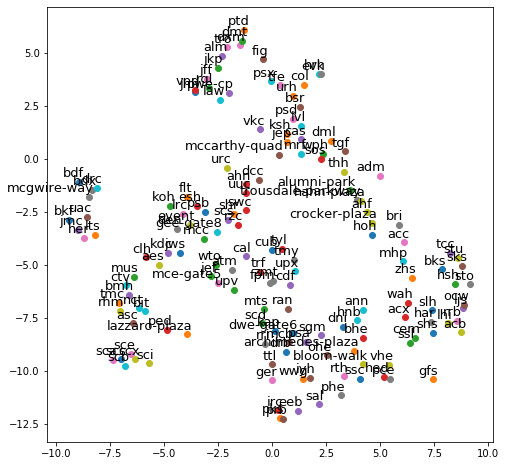

In [97]:
frequency = defaultdict(int)

data = list(b.building.values)

for device in data:
    for bld in device:
        frequency[bld] += 1

# Only keep words that appear more than once
processed_data = [[bld for bld in device] for device in data]
print(len(processed_data))

dictionary = corpora.Dictionary(processed_data)
print(dictionary)

# bag of words
bow_data = [dictionary.doc2bow(device) for device in processed_data]

w2v_model = models.fasttext.FastText(size = 5 ,window = 10)
#w2v_model = models.Word2Vec(window=10, size=10, sample=6e-5, alpha=0.001, negative=10)
w2v_model.build_vocab(data)
w2v_model.train(data, total_examples=w2v_model.corpus_count, epochs=50, start_alpha=0.01,end_alpha=0.001)

labels = []
tokens = []

for word in w2v_model.wv.vocab:
    tokens.append(w2v_model[word])
    labels.append(word)
    
tsne_model = TSNE(n_components=2, init='pca', n_iter=2500, random_state=23)
    
new_values = tsne_model.fit_transform(tokens)


x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(8, 8)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                 fontsize = 13)
plt.show()

# User Clustering 1 - based on places visited

In [99]:
def wcd(str1, str2, w2v_model):
    
    l1 = str1.split(' ')
    l2 = str2.split(' ')
    
    vec1 = np.sum(np.asarray([w2v_model.wv.get_vector(word) for word in l1]), axis = 0)/len(l1)
    vec2 = np.sum(np.asarray([w2v_model.wv.get_vector(word) for word in l2]), axis = 0)/len(l2)
    
    return distance.cosine(vec1, vec2)

wcd('her jmc trf uac', 'her bkf', w2v_model)

0.06201517581939697

In [127]:
# device data all dates
pc = df_agg['duration']/(df_agg['end'] - df_agg['begin'])

# filter data
print(df_agg[df_agg['duration'] <= timedelta(minutes = 2)].shape[0]/df_agg.shape[0])
df_agg_fl2 = df_agg[df_agg['duration'] >= timedelta(minutes = 30)]

# merge data
e = df_agg_fl2.groupby(['device_id'], as_index = False).agg(building = ('building', lambda x: list(x.values)))

visit_length = e.apply(lambda row: len(row['building']), axis = 1)
visit_length_unique = e.apply(lambda row: np.unique(np.asarray(row['building'])).shape[0], axis = 1)

e = e[visit_length_unique > 1]

print(e.shape)

frequency_e = defaultdict(int)
data_e = list(e.building.values)
texts_e = [' '.join(device) for device in data_e]
copura_e = [[w for w in sen ] for sen in data_e]
print(len(texts_e))
print(texts_e[0:10])

dictionary_e = corpora.Dictionary(copura_e)
print(dictionary)

C:\Users\Administrator\miniconda3\envs\min\lib\site-packages\pandas\core\arrays\timedeltas.py:569: RuntimeWarning: invalid value encountered in true_divide
  return other / self._data


0.5849212532731757
(3257, 2)
3257
['den den den den den den den event den den den den', 'cdf psd rri thh cdf rri wph cdf rri thh cdf rri cdf den phe cdf rri cdf rri cdf rri cdf rri vkc wph cdf lvl rri wph cdf cdf mccarthy-quad rri wph cdf rri cdf rri vkc cdf jhh rri wph cdf den rri', 'den den psb den den den den den den psb den', 'hsh rrb sto acb gfs hsh rrb sto gfs hsh rrb sto acb hsh rrb sto hsh rrb zhs gfs hsh rrb sto acb hsh rrb sto hsh rrb acb hsh rrb hsh rrb sto hsh rrb sto hsh rrb zhs hsh rrb sto', 'evk her hrh evk her hrh bsr evk her hrh bsr evk her bsr evk bsr evk her bsr evk her bsr evk her bsr evk her', 'den den den den den event den den den den den den den den', 'pks prb pks prb prb prb prb jef prb event prb prb event prb jef prb prb eeb prb prb eeb prb event jef prb prb prb event prb event prb jef prb', 'esh esh flt esh esh esh esh esh esh flt esh esh esh esh esh esh esh esh esh esh esh esh', 'zhs zhs zhs zhs zhs bri shs zhs zhs hahn-plaza zhs zhs zhs zhs zhs zhs zhs', 'wt

Estimated number of clusters: 3
For n_clusters = 3 The average silhouette_score is : 0.3319642
Estimated number of clusters: 7
For n_clusters = 7 The average silhouette_score is : 0.19025072
Estimated number of clusters: 8
For n_clusters = 8 The average silhouette_score is : 0.20368859
Estimated number of clusters: 9
For n_clusters = 9 The average silhouette_score is : 0.27925906
Estimated number of clusters: 10
For n_clusters = 10 The average silhouette_score is : 0.26535195
Estimated number of clusters: 11
For n_clusters = 11 The average silhouette_score is : 0.26958328
Estimated number of clusters: 12
For n_clusters = 12 The average silhouette_score is : 0.26662055
Estimated number of clusters: 13
For n_clusters = 13 The average silhouette_score is : 0.26040113
Estimated number of clusters: 14
For n_clusters = 14 The average silhouette_score is : 0.24444608
Estimated number of clusters: 15
For n_clusters = 15 The average silhouette_score is : 0.24899697
Estimated number of clusters:

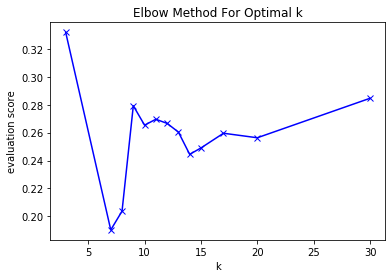

In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

np.random.seed(21)

# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(processed_data)

# document vector
vc_data_e = [ np.sum([w2v_model.wv.get_vector(w) for w in sen], axis=0)/len(sen) for sen in copura_e]
X = np.asarray(vc_data_e)

# kmeans
evl_score = []
K = [3,7,8,9,10,11,12,13,14, 15,17, 20, 30]
for k in K:
    cl =  AgglomerativeClustering(n_clusters=k,linkage="average", affinity='cosine').fit(X)
    labels = cl.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    silhouette_avg = silhouette_score(X, labels)

    print('Estimated number of clusters: %d' % n_clusters_)
    print("For n_clusters =",k, "The average silhouette_score is :", silhouette_avg)
    
    evl_score.append(silhouette_avg)

plt.plot(K, evl_score, 'bx-')
plt.xlabel('k')
plt.ylabel('evaluation score')
plt.title('Elbow Method For Optimal k')
plt.show()

In [129]:
true_k = 9

cl =  AgglomerativeClustering(n_clusters=true_k,linkage="complete", affinity='cosine').fit(X)
labels = cl.labels_

result={'cluster':labels,'data':copura_e}
result=pd.DataFrame(result)
result['cluster'].value_counts()

0    1044
6     506
3     363
8     345
4     279
2     276
5     251
1     116
7      77
Name: cluster, dtype: int64

In [140]:
for i in result[result['cluster'] == 8]['data'].explode().value_counts().index.values[0:10]:
    print(i, end = ", ")

jmc, uac, lts, her, sgm, bdf, bkf, mts, bdx, jef, 

# User Clustering 2 - based on temporal pattern

In [ ]:
df_agg

In [ ]:
g = df_agg.groupby(['device_id','date'], as_index = False)

d = g.agg(stay_time = ('duration', 'sum'))

In [ ]:
d_f = d[(d['stay_time']<= timedelta(hours = 20)) & (d['stay_time'] >= timedelta(minutes = 60))]

n_days = d_f.groupby('device_id').agg(days = ('date', 'count'))

device_remain = list(n_days[n_days['days'] > 10].index.values)

d_f = d_f[d_f['device_id'].isin(device_remain)]

print(d_f.shape)

d_ariv = d_f.copy()

d_ariv['arrived'] = 1

d_ariv = d_ariv.drop('stay_time', axis = 1)

f = d_ariv.set_index(['device_id', 'date']).unstack(level = -1, fill_value = 0)

print(f.shape)

f.columns = f.columns.droplevel()

In [ ]:
s = f.iloc[3].values

for s in f.values[0:100]:
    for i in range(len(s)//7):
        for j in range(i*7, (i+1)*7):
            print(s[j], end=' ')
        print()
    print('==============================')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

np.random.seed(21)

# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(processed_data)

# document vector
X = f.values

# kmeans
evl_score = []
K = [3,7,8,9,10,11,12,13,14, 15,17, 20, 30,50,100,150,200]
for k in K:
    cl =  KMeans(n_clusters=k).fit(X)
    labels = cl.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
#     silhouette_avg = silhouette_score(X, labels)

    silhouette_avg = cl.inertia_

    print('Estimated number of clusters: %d' % n_clusters_)
    print("For n_clusters =",k, "The average silhouette_score is :", silhouette_avg)
    
    evl_score.append(silhouette_avg)

plt.plot(K, evl_score, 'bx-')
plt.xlabel('k')
plt.ylabel('evaluation score')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
true_k = 25
X = f.values
cl =  KMeans(n_clusters=true_k).fit(X)
labels = cl.labels_

result={'cluster':labels}
result=pd.DataFrame(result)
result['cluster'].value_counts()

In [ ]:
ff = f.iloc[result[result['cluster'] == 12].index,:]
s = ff.iloc[3].values

for s in ff.values[0:100]:
    for i in range(len(s)//7):
        for j in range(i*7, (i+1)*7):
            print(s[j], end=' ')
        print()
    print('==============================')

In [ ]:
ff = f.iloc[result[result['cluster'] == 10].index,:]

s = 100
x = ff.iloc[1].index.values
y = ff.iloc[1].values

#y = np.mean(y, axis = 0)

plt.plot(x,y)

plt.show()